In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib import colors
from matplotlib.colors import LogNorm

%matplotlib inline
from scipy.optimize import curve_fit, minimize
import straxbra
from matplotlib.ticker import AutoMinorLocator
from matplotlib.image import NonUniformImage
import pandas as pd
import patrick_stylez as ps
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import chi2 

import sys
sys.path.append("/data/workspace/Patrick/Analysis")
import functions as fc

Using TensorFlow backend.


In [2]:
 
def Process(waveform,i,drifttime_list, s1_list,s2_list, z_list,cs1_list, aii, bii, timestamp): 
    SelectionCutFlag = fc.CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  fc.S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if fc.S2_found(integral = integral[i+j], width = width[i+j]):
                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = fc.drifttime_to_z(t=(timestamp[i+j] - timestamp[i]), ai=aii, bi=bii)
                while threshold_timestamp >= s2_counter_timestamp and fc.S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5:
                        s1.append(integral[i])
                        z.append(z_position)
                        cs1.append(integral[i]/(-0.0069 *z_position + 0.76))
                        time       = timestamp[i+j] - timestamp[i]
                        drifttime.append(time)
                        s2.append(integral[i+j])
                        return
                    else:
                        return
                return
            else:
                return
    else:
        return
    

    
def Process_2(waveform,i, aii, bii, timestamp,cs2_list,electron_lifetime): 
    SelectionCutFlag = fc.CutCondition(waveform[i])
    if SelectionCutFlag == True:
        j = 1
        counter_timestamp = timestamp[i+j]
        threshold_timestamp = timestamp[i] + 45000
        while threshold_timestamp >= counter_timestamp and  fc.S2_found(integral = integral[i+j], width = width[i+j]) == False:  
            j += 1
            counter_timestamp = timestamp[i+j]
        else:
            if fc.S2_found(integral = integral[i+j], width = width[i+j]):
                k=1 
                s2_counter_timestamp = timestamp[i+j+k]
                z_position = fc.drifttime_to_z(t=(timestamp[i+j] - timestamp[i]), ai=aii, bi=bii)
                while threshold_timestamp >= s2_counter_timestamp and fc.S2_found(integral = integral[i+j+k], width = width[i+j+k]) == False:
                    k += 1
                    s2_counter_timestamp = timestamp[i+j+k]
                else:

                    if threshold_timestamp <= s2_counter_timestamp and z_position >= -70 and z_position <= -5 and integral[i+j] < 50000:
                        time       = timestamp[i+j] - timestamp[i]
                        S2 = integral[i+j]
                        s2_corrected= S2/(np.exp(-time/(electron_lifetime*1e3)))
                        cs2.append(s2_corrected)
                        return
                    else:
                        return
                return
            else:
                return
    else:
        return
    
    
def compute_lifetime(s2,drifttime):

    bins_x = np.linspace(0,50,50)
    bins_y = np.logspace(2,5,50) 
    drifttime = np.array(drifttime)
    counts, xedges, yedges = np.histogram2d(drifttime/1e3, s2, bins=(bins_x, bins_y))
    ycenter = ((yedges[:-1]+yedges[1:])/2)
    poisson_list = []
    for i in counts:
        error_per_slice = []
        for j in i:
            u =fc.poisson_interval(j)[1]
            error_per_slice.append(u)
        poisson_list.append(error_per_slice)
        
    fit_range= np.linspace(10,30000,1000)

    

    p0 = [50,8,2]

    expectation_list = []
    error_list = []
    for i in range(5,35):   
        popt, pcov = curve_fit(fc.log_gaus, ycenter, counts[i], p0= p0, sigma = poisson_list[i], absolute_sigma = True, maxfev = 100000)
        perr = np.sqrt(np.diag(pcov))

        
#         expectation = np.exp(popt[1]-popt[2]**2)
#         expectation_list.append(expectation)
#         diff_mu = expectation
#         diff_sigma = expectation * 2 * popt[2]
#         error_mu = perr[1]
#         error_sigma = perr[2] 
#         error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
#         error_list.append(error)
        
        
        
        
        
        
        expectation = np.exp(popt[1]+((popt[2]**2)/2))
        expectation_list.append(expectation)

    
        diff_mu = expectation
        diff_sigma = expectation*popt[2]
        error_mu = perr[1]
        error_sigma = perr[2]
    
        error = np.sqrt(diff_mu**2 * error_mu**2 + diff_sigma**2 * error_sigma**2)
        error_list.append(error)
    
 
    p1=  [10000,0.1]
    x = np.linspace(5,35,30)
    popt, pcov = curve_fit(fc.expo, x, expectation_list, sigma=error_list, p0=p1, absolute_sigma=True, maxfev= 10000)
    perr = np.sqrt(np.diag(pcov))
    lifetime =(1/popt[1])
    lifetime_error =(1/(popt[1]**2))*perr[1]

    return (lifetime, lifetime_error)



In [3]:
left_edge  = [0, 0]
right_edge = [40500.0, -71.5]
a = ((right_edge[1])-(left_edge[1])) / ((right_edge[0])-(left_edge[0]))
b = (right_edge[1]) - a * (right_edge[0])
fiducial_r = 23
shape = -0.0069
offset = 0.76




In [4]:
z_dict = {}
s1_dict = {}
cs1_dict = {}
s2_dict = {}
cs2_dict = {}
drifttime_dict = {}

run_list = ['00201','00200','00199','00198','00197','00196','00195','00194','00193','00192']
# run_list = ['00199']
electron_lifetime_list = []
lifetime_error_list = []

for run in run_list:

    ctx = straxbra.XebraContext()
    peaks_data = ctx.get_array(run, 'peaks')
    waveform = peaks_data['data']
    integral = peaks_data['area']
    width = peaks_data['width'][:,5]
    ts = peaks_data['time']

    
    z = []
    s1 = []
    cs1 = []
    s2 = []
    cs2 = []
    drifttime = []
    
    

    num = len(waveform)
    print_counter = 0.0
    for i in range(0,num-10):    
        Process(waveform,i,drifttime_list = drifttime,s1_list = s1, s2_list = s2,z_list = z,cs1_list = cs1, aii=a, bii=b, timestamp=ts)
        if i/num >= print_counter:
            print(round(print_counter,2), end = ' ')
            print_counter += 0.1
    print(1.0, '        Run ',run, 'done!')
    
    
    lifetime, lifetime_error = compute_lifetime(s2,drifttime)
    electron_lifetime_list.append(lifetime)
    lifetime_error_list.append(lifetime_error)
    
    print_counter = 0.0
    for i in range(0,num-10):    
        Process_2(waveform,i, aii=a, bii=b, timestamp=ts,cs2_list=cs2, electron_lifetime=lifetime)
        if i/num >= print_counter:
            print(round(print_counter,2), end = ' ')
            print_counter += 0.1
    print(1.0, '        Run ',run, 'done!')
    
    z_dict.update({run:z})
    s1_dict.update({run:s1})
    cs1_dict.update({run:cs1})
    s2_dict.update({run:s2})
    cs2_dict.update({run:cs2})
    drifttime_dict.update({run:drifttime})


0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00201 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00201 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00200 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00200 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00199 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00199 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00198 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00198 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00197 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00197 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00196 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00196 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00195 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.0         Run  00195 done!
0.0 0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.

In [5]:
print(electron_lifetime_list)

[43.438427776817925, 68.52850264697969, 85.61642087281577, 97.35761285767376, 100.81913222589843, 131.66907973361955, 121.15352386756179, 151.43998282580233, 126.07864624245346, 131.94202497577461]


In [6]:
p0_log_s2 = [10,10,10]
p0_log_s1 = [1,1,1]

cs1_list = []
cs1_error_list = []
cs1_rcq_list = []
cs2_list = []
cs2_error_list = []
cs2_rcq_list = []
cs1_ly_list = []
cs1_ly_error_list = []
cs2_ly_list = []
cs2_ly_error_list = []

for i in run_list:
    poisson_list_s1 = []
    poisson_list_s2 = []

    n_s1, binEdges_s1 = np.histogram(cs1_dict[i], bins=np.linspace(1,700,100))
    n_s2, binEdges_s2 = np.histogram(cs2_dict[i], bins=np.linspace(1,15000,100))

    for j in n_s1:
        q= fc.poisson_interval(j)[1]
        poisson_list_s1.append(q)
    for k in n_s2:
        m= fc.poisson_interval(k)[1]
        poisson_list_s2.append(m)
    bincenters_s1 = 0.5 * (binEdges_s1[1:] + binEdges_s1[:-1])
    bincenters_s2 = 0.5 * (binEdges_s2[1:] + binEdges_s2[:-1])
    
    popt_s1, pcov_s1 = curve_fit(fc.log_gaus, bincenters_s1, n_s1, p0_log_s1,  sigma = poisson_list_s1, absolute_sigma = True, maxfev = 10000)
    perr_s1 = np.sqrt(np.diag(pcov_s1))
    popt_s2, pcov_s2 = curve_fit(fc.log_gaus, bincenters_s2, n_s2, p0_log_s2,  sigma = poisson_list_s2, absolute_sigma = True, maxfev = 10000)
    perr_s2 = np.sqrt(np.diag(pcov_s2))
    
    expectation_s1 = np.exp(popt_s1[1]+((popt_s1[2]**2)/2))
    diff_mu_s1 = expectation_s1
    diff_sigma_s1 = expectation_s1*popt_s1[2]
    error_mu_s1 = perr_s1[1]
    error_sigma_s1 = perr_s1[2]   
    error_s1 = np.sqrt(diff_mu_s1**2 * error_mu_s1**2 + diff_sigma_s1**2 * error_sigma_s1**2)

    xdata_s1=bincenters_s1[1:-1]
    ydata_s1=n_s1[1:-1]
    chi_squared_s1 =  (np.sum((n_s1 - fc.log_gaus(bincenters_s1, *popt_s1))**2 / np.array(poisson_list_s1)**2))
    Reduced_chi_squared_s1 ="%.2f" %( chi_squared_s1 / len(xdata_s1))
    
    expectation_s2 = np.exp(popt_s2[1]+((popt_s2[2]**2)/2))
    diff_mu_s2 = expectation_s2
    diff_sigma_s2 = expectation_s2*popt_s2[2]
    error_mu_s2 = perr_s2[1]
    error_sigma_s2 = perr_s2[2]   
    error_s2 = np.sqrt(diff_mu_s2**2 * error_mu_s2**2 + diff_sigma_s2**2 * error_sigma_s2**2)

    xdata_s2=bincenters_s2[1:-1]
    ydata_s2=n_s2[1:-1]
    chi_squared_s2 =  (np.sum((n_s2 - fc.log_gaus(bincenters_s2, *popt_s2))**2 / np.array(poisson_list_s2)**2))
    Reduced_chi_squared_s2 ="%.2f" %( chi_squared_s2 / len(xdata_s2))
    s2_mu = f"{expectation_s2:.0f}"
    s2_error = f"{error_s2:.0f}"
    
    
    
    
    plt.show()
    
    cs1_list.append(expectation_s1)
    cs1_error_list.append(error_s1)
    cs1_rcq_list.append(Reduced_chi_squared_s1)
    
    cs2_list.append(expectation_s2)
    cs2_error_list.append(error_s2)
    cs2_rcq_list.append(Reduced_chi_squared_s2)
    
    cs1_ly = np.array(expectation_s1)/41.5
    cs1_ly_list.append(cs1_ly)
    cs1_ly_error = np.array(error_s1)/41.5
    cs1_ly_error_list.append(cs1_ly_error)
    
    cs2_ly = np.array(expectation_s2)/41.5
    cs2_ly_list.append(cs2_ly)
    cs2_ly_error = np.array(error_s2)/41.5
    cs2_ly_error_list.append(cs2_ly_error)
# def Average(lst): 
#     return sum(lst) / len(lst)

# average = Average(counts[:18])
# print(average)

In [7]:
print(cs1_list)
print (cs2_rcq_list)
print(cs1_ly_list)
print(cs1_ly_error_list)
print(cs2_ly_list)
print(cs2_ly_error_list)

[304.42232035542065, 301.0054027238707, 298.26527807273993, 293.5873778156478, 288.2703793262821, 285.2007082685384, 280.89820004717893, 278.36837306116416, 275.2708799733516, 273.0486460293432]
['7.39', '7.96', '6.83', '5.93', '4.62', '3.63', '2.62', '2.29', '1.80', '1.84']
[7.335477598925799, 7.253142234310137, 7.18711513428289, 7.074394646160188, 6.9462742006333045, 6.872306223338274, 6.768631326438046, 6.707671640028052, 6.633033252369918, 6.579485446490198]
[0.008456579463231823, 0.007859829638032688, 0.008066933878268887, 0.008497687364488062, 0.008224684683201153, 0.008915798172470665, 0.009122567044926151, 0.009364988352462592, 0.009527544980251742, 0.0096257118896756]
[72.49114999140599, 79.3247870990492, 89.00560685531093, 95.11714556709292, 103.0285107093216, 106.24966714509975, 114.19972466577953, 114.72538452985843, 124.74485228170258, 128.02046580862182]
[0.617468316849399, 0.5558469194048953, 0.6014688093912325, 0.6495430716024944, 0.6568273265599015, 0.7039490727645048,

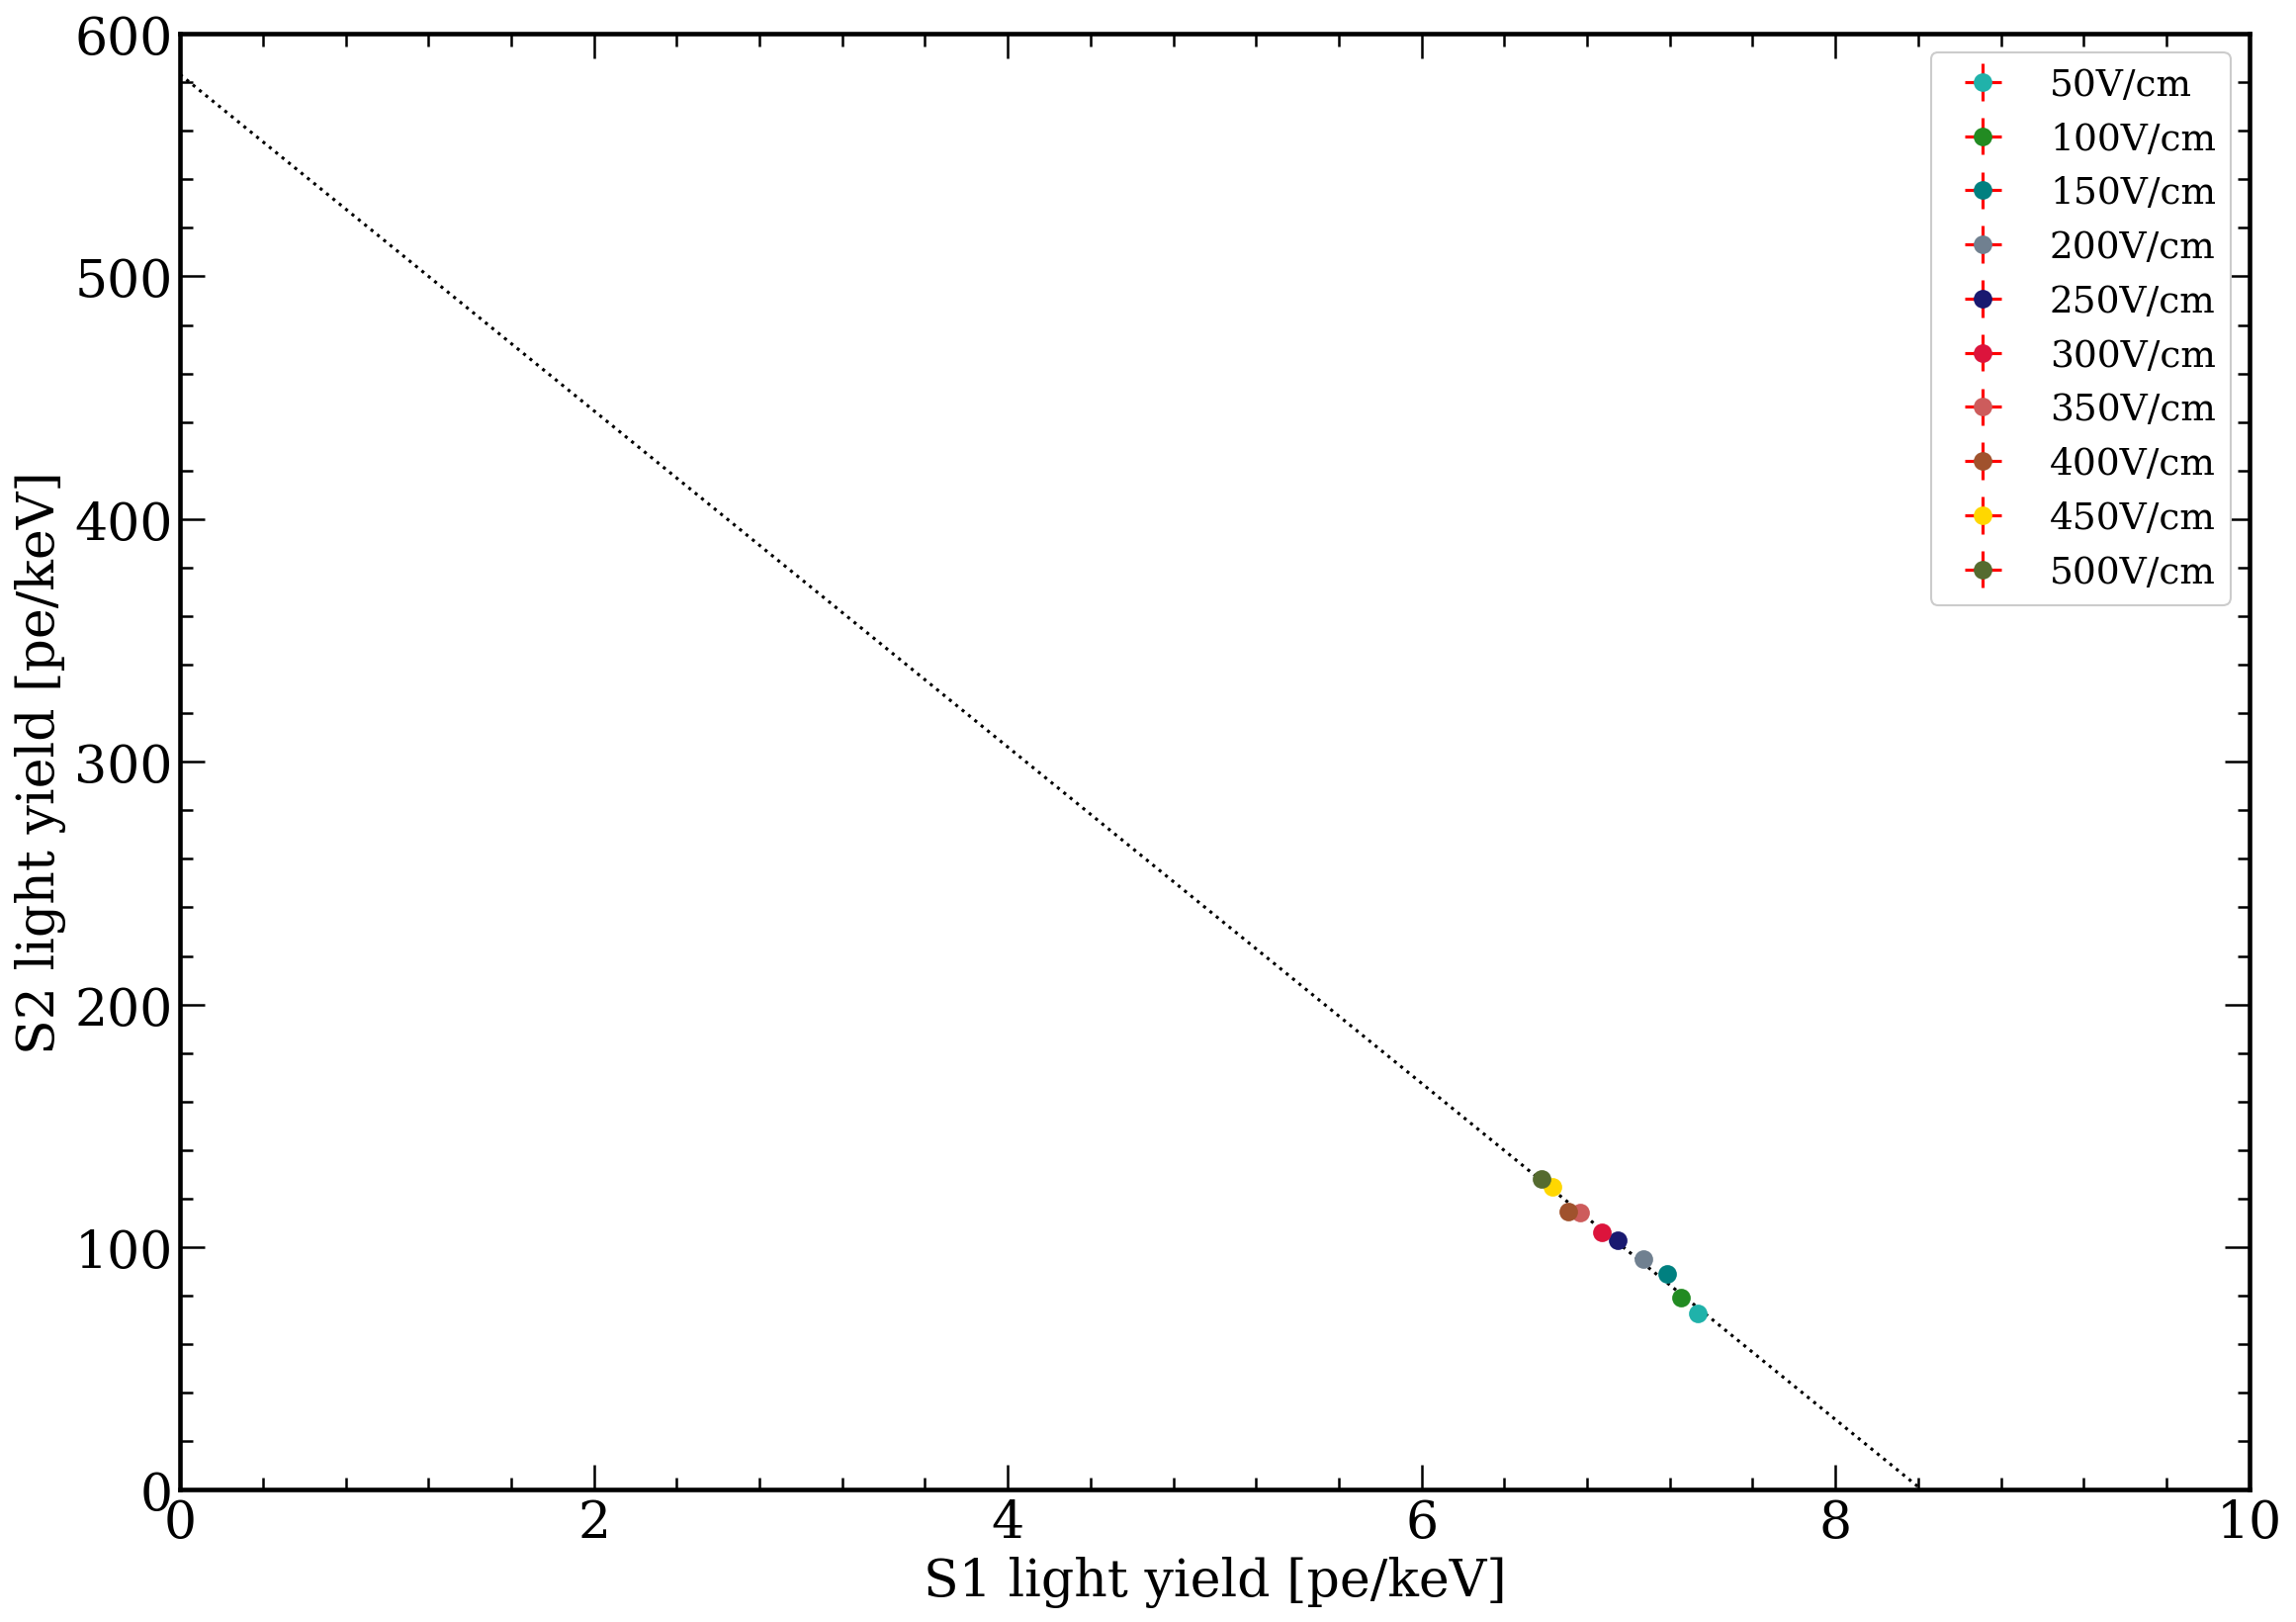

In [14]:
fig, axes = ps.styles()
p0= [-1, 800]
colors = ['lightseagreen','forestgreen','teal','slategrey','midnightblue','crimson','indianred', 'sienna','gold','darkolivegreen']
field = ['50','100','150','200','250','300','350','400','450','500']
x_range = np.linspace(0,10, 100)
cs2_ly = np.array(cs2_list)/41.5
cs2_ly_error = np.array(cs2_error_list)/41.5
cs1_ly = np.array(cs1_list)/41.5
cs1_ly_error = np.array(cs1_error_list)/41.5

popt_anti, pcov = curve_fit(fc.linear, cs1_ly, cs2_ly, p0,  sigma = cs2_ly_error, absolute_sigma = True, maxfev = 100000)
perr = np.sqrt(np.diag(pcov))

for i in range(len(field)):
    
    axes.errorbar(cs1_ly[i], cs2_ly[i], xerr = cs1_ly_error[i], yerr = cs2_ly_error[i],marker = 'o', fmt='.',c = colors[i],markersize='8',ecolor='red', label=field[i]+'V/cm')

    
axes.plot(x_range,fc.linear(x_range,*popt_anti), color = 'k',linestyle = ':')

# handles,labels = axes.get_legend_handles_labels()
# handles = [handles[0]]
# labels = [labels[0]]
# axes.legend(handles,labels, loc = 1,prop={'size': 18}, fancybox=True, framealpha=1)
axes.legend(loc = 1,prop={'size': 18}, fancybox=True, framealpha=1)

axes.set_ylabel('S2 light yield [pe/keV]')
axes.set_xlabel('S1 light yield [pe/keV]')
axes.set_xlim([0,10])
axes.set_ylim([0,600])
plt.show()

In [9]:
print(popt_anti[1])

583.221170918359


In [10]:
def GetDetectorGains(params0,params1, error0, error1):
    W = 13.7
    g2 = popt_anti[1]/1000*W
    g2_error = perr[1]/1000*W
    g1 = g2/(-popt_anti[0])
    g1_error = np.sqrt(     (1/popt_anti[0])**2   *g2_error**2 + (g1**2)/(popt_anti[0]**4)      *perr[0]**2     )
    return g1, g2, g2_error, g1_error

In [11]:
GetDetectorGains(params0 = popt_anti[0], params1= popt_anti[1],error0 = perr[1], error1= perr[0])

(0.11533323733186222,
 7.990130041581518,
 0.08127085692192426,
 0.001173278092727468)

In [12]:
g1,g2,g2_error,g1_error = GetDetectorGains(params0 = popt_anti[0], params1= popt_anti[1],error0 = perr[1], error1= perr[0])


print('g1 = (', g1, '+/-', g1_error,')')
print('g2 = (', g2, '+/-', g2_error,')')

g1 = ( 0.11533323733186222 +/- 0.001173278092727468 )
g2 = ( 7.990130041581518 +/- 0.08127085692192426 )
